# Skin cancer detection

Dataset taken from Kaggle at [Skin Cancer ISIC](https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic).

In [1]:
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os, shutil
import pandas as pd

import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits, load_sample_images
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer

import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from scikeras.wrappers import KerasClassifier

# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'

# Get all the data in the directory data/validation (132 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, batch_size=118)

# Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, batch_size=2239)

# Create the datasets
train_images_fs, train_labels = next(train_generator)
test_images_fs, test_labels = next(test_generator)
#val_images, val_labels = next(val_generator)

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


In [3]:
train_images_fs

array([[[[ 46.,  39.,  29.],
         [ 44.,  40.,  28.],
         [ 53.,  46.,  38.],
         ...,
         [ 51.,  45.,  33.],
         [ 53.,  48.,  42.],
         [ 42.,  38.,  37.]],

        [[ 51.,  36.,  33.],
         [ 52.,  37.,  34.],
         [ 58.,  44.,  41.],
         ...,
         [ 57.,  43.,  34.],
         [ 56.,  45.,  39.],
         [ 47.,  43.,  40.]],

        [[ 61.,  47.,  46.],
         [ 57.,  45.,  45.],
         [ 56.,  47.,  42.],
         ...,
         [ 64.,  53.,  49.],
         [ 55.,  46.,  41.],
         [ 43.,  39.,  36.]],

        ...,

        [[ 46.,  37.,  40.],
         [ 48.,  37.,  41.],
         [ 48.,  38.,  36.],
         ...,
         [ 28.,  24.,  25.],
         [ 30.,  30.,  28.],
         [ 29.,  25.,  22.]],

        [[ 44.,  32.,  36.],
         [ 49.,  37.,  37.],
         [ 50.,  40.,  39.],
         ...,
         [ 35.,  26.,  29.],
         [ 29.,  28.,  33.],
         [ 29.,  29.,  29.]],

        [[ 47.,  31.,  41.],
       

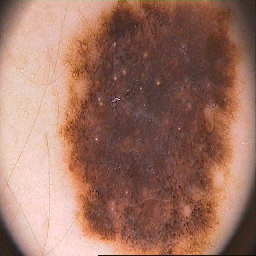

In [4]:
# Preview an image
array_to_img(train_images_fs[0])

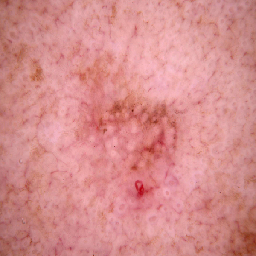

In [5]:
# Preview an image
array_to_img(test_images_fs[0])

In [6]:
train_labels.shape

(2239, 9)

In [7]:
test_labels.shape

(118, 9)

In [8]:
test_images_fs.shape

(118, 256, 256, 3)

In [9]:
train_images_fs.shape

(2239, 256, 256, 3)

In [10]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [11]:
type(train_labels)

numpy.ndarray

In [12]:
type(train_images_fs)

numpy.ndarray

In [13]:
dataframe=pd.DataFrame(train_labels, columns=['actinic_keratosis', 'basal_cell_carcinoma',\
            'dermatofibroma', 'melanoma', 'nevus', 'pigmented_benign_keratosis',\
            'seborrheic_keratosis', 'squamous_cell_carcinoma', 'vascular_lesion'])

In [14]:
dataframe

,actinic_keratosis,basal_cell_carcinoma,dermatofibroma,melanoma,nevus,pigmented_benign_keratosis,seborrheic_keratosis,squamous_cell_carcinoma,vascular_lesion
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2234,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2235,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2236,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2237,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
#dataframe.hist()

In [16]:
sums=dataframe.sum(axis=0)

In [17]:
sums=pd.DataFrame(sums)

In [18]:
sums

,0
actinic_keratosis,114.0
basal_cell_carcinoma,376.0
dermatofibroma,95.0
melanoma,438.0
nevus,357.0
pigmented_benign_keratosis,462.0
seborrheic_keratosis,77.0
squamous_cell_carcinoma,181.0
vascular_lesion,139.0


In [19]:
sums['%'] = ((sums[0] / 2239*100).round(2).astype(str) + '%')

In [20]:
sums

,0,%
actinic_keratosis,114.0,5.09%
basal_cell_carcinoma,376.0,16.79%
dermatofibroma,95.0,4.24%
melanoma,438.0,19.56%
nevus,357.0,15.94%
pigmented_benign_keratosis,462.0,20.63%
seborrheic_keratosis,77.0,3.44%
squamous_cell_carcinoma,181.0,8.08%
vascular_lesion,139.0,6.21%


In [212]:
#Change this into seaborn to make it even cooler
sums.plot(kind='bar');

Melanoma is cancer 438
acitinic keartosis is pre cancer 114
basal cell is cancer 376
squamous cell cancer 181


dermatofibroma bening 95
benign keratosis 462
nevus bening 357
seborrheic bening 77 
vascular lesion bening 139

In [22]:
train_generator.class_indices 

{'actinic keratosis': 0,
 'basal cell carcinoma': 1,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevus': 4,
 'pigmented benign keratosis': 5,
 'seborrheic keratosis': 6,
 'squamous cell carcinoma': 7,
 'vascular lesion': 8}

Defining a function to visualize the results.

In [23]:
"""def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()"""

"def visualize_training_results(results):\n    history = results.history\n    plt.figure()\n    plt.plot(history['val_loss'])\n    plt.plot(history['loss'])\n    plt.legend(['val_loss', 'loss'])\n    plt.title('Loss')\n    plt.xlabel('Epochs')\n    plt.ylabel('Loss')\n    plt.show()\n    \n    plt.figure()\n    plt.plot(history['val_accuracy'])\n    plt.plot(history['accuracy'])\n    plt.legend(['val_accuracy', 'accuracy'])\n    plt.title('Accuracy')\n    plt.xlabel('Epochs')\n    plt.ylabel('Accuracy')\n    plt.show()"

Look at lab on https://github.com/learn-co-curriculum/dsc-image-classification-with-mlps-lab/tree/solution
might need to do some one hot encoding.
Also, just like it shows there, as a naive model maybe decrease the number of layers and keep epochs at like 5.
If results are the same, try to understand why the loss still showes such high peaks.And why the accuracy drops like that.
Might also be worth doing CNN from the start with 2D layers instead of this basic NN.

Let us forget about all of this and try with the 2D actual convolutional neural network for images. The perfmormance there might be different.

We can also do something else which is group together the types of skin abnormalities that are cancerous and the ones that are not, reducing the classes to 2 and making this a binary classification problem.
I will do that later on. For now let's see what happens with a convolutional neural network, which is what I should be doing anyway.

Here also definitely preview one image per class and explain a bit about each class.

## Preprocessing

In [24]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'
#val_data_dir = 'dataset/validation_set'

# Get all the data in the directory data/validation (118 images), and reshape them
test_gen= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(32, 32), batch_size=118)

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(32, 32), batch_size=2239)

# Create the datasets
train_img32, train_lab = next(train_gen)
test_img32, test_lab = next(test_gen)

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


In [25]:
# Explore your dataset again
m_train = train_img32.shape[0]
num_px = train_img32.shape[1]
m_test = test_img32.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("train_images shape: " + str(train_img32.shape))
print ("train_labels shape: " + str(train_lab.shape))
print ("test_images shape: " + str(test_img32.shape))
print ("test_labels shape: " + str(test_lab.shape))

Number of training samples: 2239
Number of testing samples: 118
train_images shape: (2239, 32, 32, 3)
train_labels shape: (2239, 9)
test_images shape: (118, 32, 32, 3)
test_labels shape: (118, 9)


In [211]:
train_y = np.reshape(train_lab[:,0], (2239,1))

Building two functions that will help us visualize and compare the different models:

In [51]:
def visualize_training_results(results):
    history = results.history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    ax1.plot(history['val_acc'])
    ax1.plot(history['acc'])
    ax1.legend(['val_acc', 'acc'], loc='best')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    
    ax2.plot(history['val_loss'])
    ax2.plot(history['loss'])
    ax2.legend(['val_loss', 'loss'], loc='best')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')

Creating the empty dataframe where we will store the results:

In [114]:
# create an Empty DataFrame object
df = pd.DataFrame()

Creating two functions to preview the results of our models.
With these functions we will display the evolution of accuracy and loss in our model, during the different epochs.
Below that we will see also the values of accuracy and loss and over time we will build a learning curve, adding the result of each previous model and the current one, to see if our model is improving.
The two different funcitons are plotting this last "lerning curve" as either a line plot or a scatter plot.

In [100]:
def model_results(results, model_name, df):
    visualize_training_results(results)
    df1 = pd.DataFrame({'Name': [model_name],
        'accuracy train': [round(results.history['acc'][-1],5)] ,
        'accuracy validation': [round(results.history['val_acc'][-1],5 )],
        'loss train': [round(results.history['loss'][-1],5)],
        'loss validation': [round(results.history['val_loss'][-1],5)]})
    df=df.append(df1)
    fig = plt.subplots(figsize=(12,6))
    
    plt.subplot(1,2,1)
    x=df['Name']
    y=df['accuracy train']
    plt.plot(x, y, color='r')
    x1=df['Name']
    y1=df['accuracy validation']
    plt.plot(x1, y1, color='g')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Accuracy')
    plt.legend()
 
    plt.subplot(1,2,2)
    x=df['Name']
    y=df['loss train']
    plt.plot(x, y, color='r')
    x1=df['Name']
    y1=df['loss validation']
    plt.plot(x1, y1, color='g')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Loss')
    plt.legend()

    plt.show()
    return df

In [ ]:
def model_results_scat(results, model_name, df):
    visualize_training_results(results)
    df1 = pd.DataFrame({'Name': [model_name],
       'accuracy train': [round(results.history['acc'][-1],5)] ,
       'accuracy validation': [round(results.history['val_acc'][-1],5 )],
       'loss train': [round(results.history['loss'][-1],5)],
       'loss validation': [round(results.history['val_loss'][-1],5)]})
    df=df.append(df1)
    fig = plt.subplots(figsize=(12,6))
    
    plt.subplot(1,2,1)
    x=df['Name']
    y=df['accuracy train']
    plt.scatter(x, y, color='r')
    x1=df['Name']
    y1=df['accuracy validation']
    plt.scatter(x1, y1, color='g')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Accuracy')
    plt.legend()
 
    plt.subplot(1,2,2)
    x=df['Name']
    y=df['loss train']
    plt.scatter(x, y, color='r')
    x1=df['Name']
    y1=df['loss validation']
    plt.scatter(x1, y1, color='g')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Loss')
    plt.legend()

    plt.show()
    return df

We will create later a function to create a model. But since we want our model to be well structured, it doesn't make sense to do so for a naive model, that needs to be instead as skimmed down and simple as possible.

In [ ]:
"""And let us create another function to generate models.
With this function we can set all the parameters that we want, input_shape, activation function, loss, optimizer algorithm, metrics etc.
We will also set most of these parameters as default, except for input shape, to make the execution of the function not too heavy."""

In [101]:
"""def create_model(input_shape, activation='relu', 
                 loss='sparse_categorical_crossentropy', 
                optimizer='rmsprop',metrics=['acc'],
                 neur1=10, neur2=32, pool=(2,2)):
 # create model
    model = models.Sequential()
    model.add(layers.Conv2D(neur1, (3, 3), activation=activation,
                        input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool))
    
    model.add(layers.Conv2D(neur1, (4, 4), activation=activation))
    model.add(layers.MaxPooling2D(pool))

    model.add(layers.Conv2D(neur2, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation=activation))
    model.add(layers.Dense(9, activation='softmax'))

# Compile model
    model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)
    return model"""

And one more function to fit the model and get the results. Also here we can set number of epochs, batch size and validation split, but there are default parameters too.

In [111]:
def fit_model(model, train, y, epo=10, batch=10, val_split=0.3, verbose=0):
    results = model.fit(train, y, epochs=epo, batch_size=batch, 
                        validation_split=val_split, verbose=verbose)
    return results

In [56]:
#visualize_training_results(history)

### Trying to pick a Naive model

Trying with a simple model:

In [109]:
model = models.Sequential()
model.add(layers.Conv2D(10, (3, 3), activation='relu',
                        input_shape=(32 ,32,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

And doing only 10 epochs:

In [112]:
history1 = fit_model(model, train_img32,train_y)

Let us visualize the results of this first model:
The bottom two graphs will make sense only later on since we are building a learning curve, to compare the different models' performance.

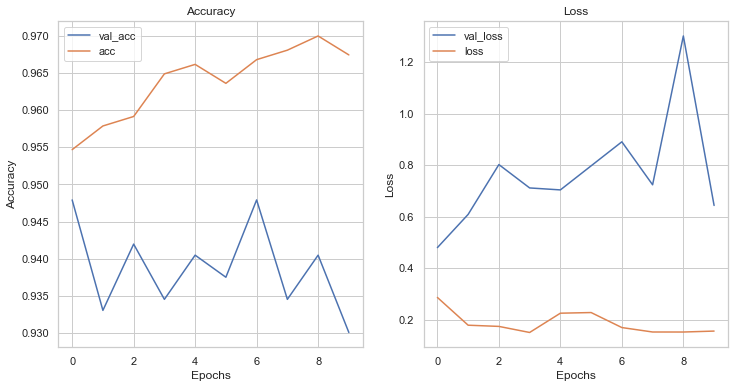

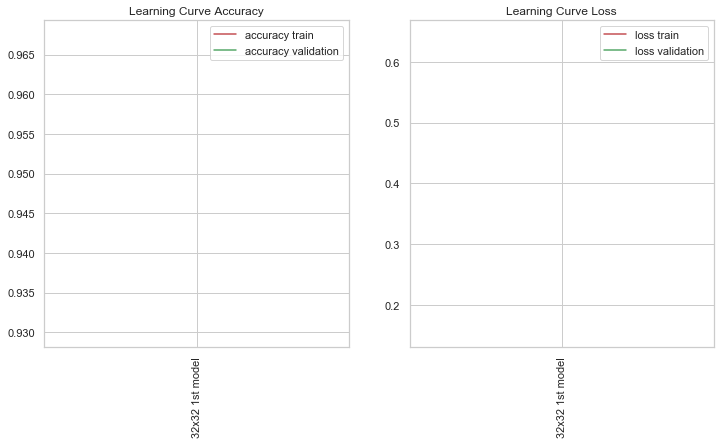

,Name,accuracy train,accuracy validation,loss train,loss validation
0,32x32 1st model,0.96745,0.93006,0.15598,0.64381


In [115]:
df=model_results(history1, '32x32 1st model', df)
df

Another attempt: all the previous parameters but making the last dense layer smaller.

In [62]:
model2 = models.Sequential()
model2.add(layers.Conv2D(10, (3, 3), activation='relu',
                        input_shape=(32 ,32,  3)))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Flatten())
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(9, activation='softmax'))

model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [116]:
history3 = fit_model(model2,train_img32,train_y)

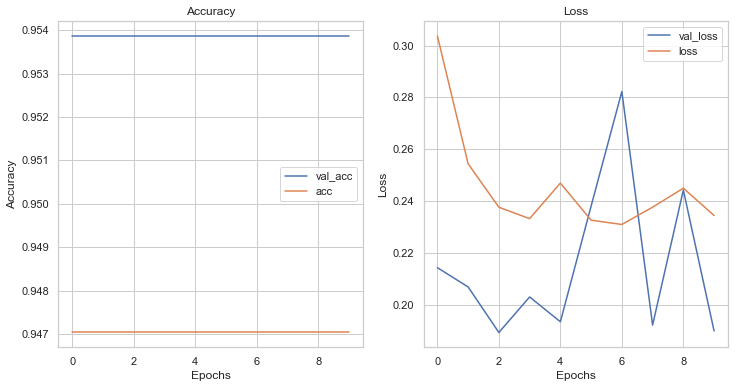

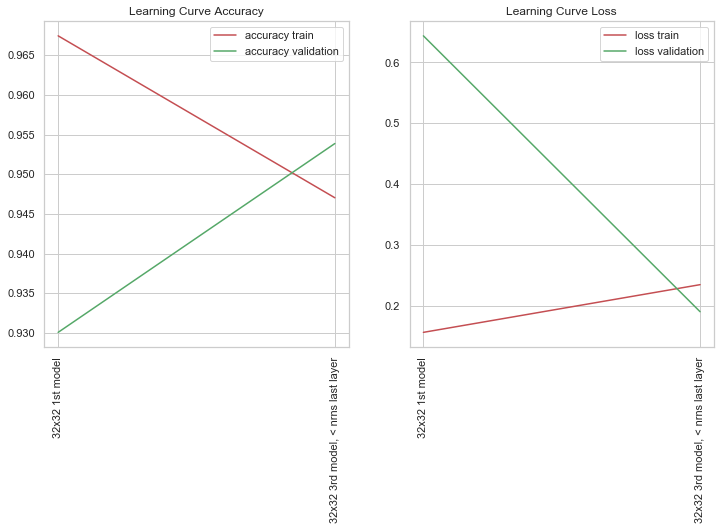

,Name,accuracy train,accuracy validation,loss train,loss validation
0,32x32 1st model,0.96745,0.93006,0.15598,0.64381
0,"32x32 3rd model, < nrns last layer",0.94703,0.95387,0.23444,0.18992


In [117]:
df=model_results(history3, '32x32 3rd model, < nrns last layer', df)
df

#### Even less Neurons:

In [65]:
model3 = models.Sequential()
model3.add(layers.Conv2D(5, (3, 3), activation='relu',
                        input_shape=(32 ,32,  3)))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Flatten())
model3.add(layers.Dense(5, activation='relu'))
model3.add(layers.Dense(9, activation='softmax'))

model3.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [118]:
history4 = fit_model(model3, train_img32,
                    train_y)

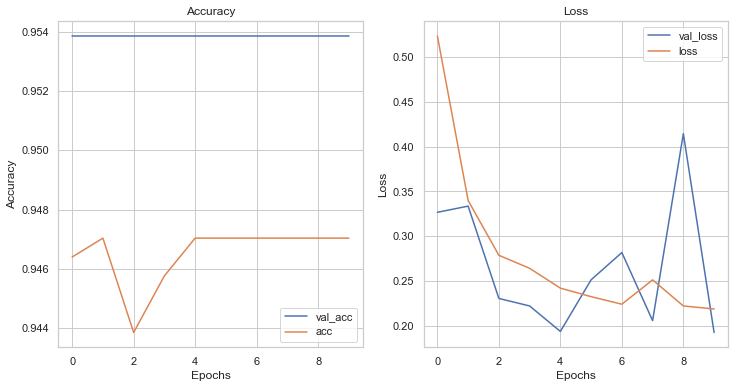

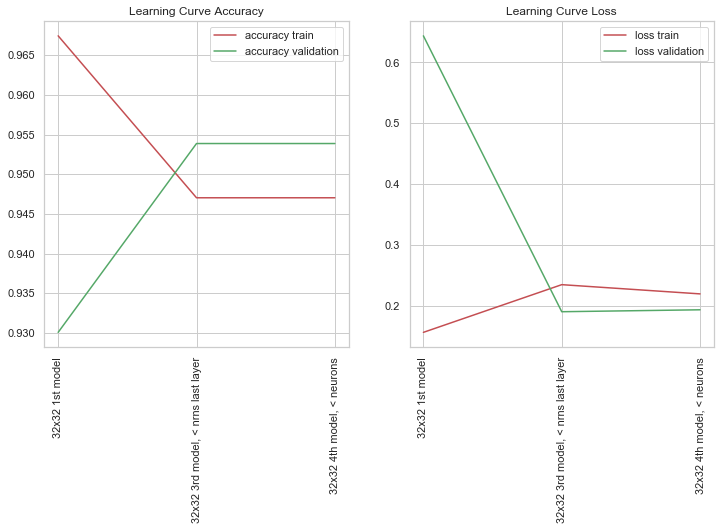

,Name,accuracy train,accuracy validation,loss train,loss validation
0,32x32 1st model,0.96745,0.93006,0.15598,0.64381
0,"32x32 3rd model, < nrns last layer",0.94703,0.95387,0.23444,0.18992
0,"32x32 4th model, < neurons",0.94703,0.95387,0.21926,0.19309


In [119]:
df=model_results(history4, '32x32 4th model, < neurons', df)
df

#### Less resolution images.

In [120]:
# Directory path
train_data_dir = 'dataskin/Train'
#test_data_dir = 'dataskin/Test'

# Get all the data in the directory data/validation (118 images), and reshape them
#test_gen= ImageDataGenerator().flow_from_directory(
#        test_data_dir, target_size=(8, 8), batch_size=118)

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(8, 8), batch_size=2239)

# Create the datasets
train_img8, train_lab = next(train_gen)
#test_img, test_lab = next(test_gen)

Found 2239 images belonging to 9 classes.


In [121]:
train_img8.shape

(2239, 8, 8, 3)

In [122]:
train_y = np.reshape(train_lab[:,0], (2239,1))
#test_y = np.reshape(test_lab[:,0], (118,1))

In [123]:
model5 = models.Sequential()
model5.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(8 ,8,  3)))
model5.add(layers.MaxPooling2D((2, 2)))

model5.add(layers.Flatten())
model5.add(layers.Dense(9, activation='softmax'))

model5.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [124]:
history5 = fit_model(model5, train_img8,
                    train_y)

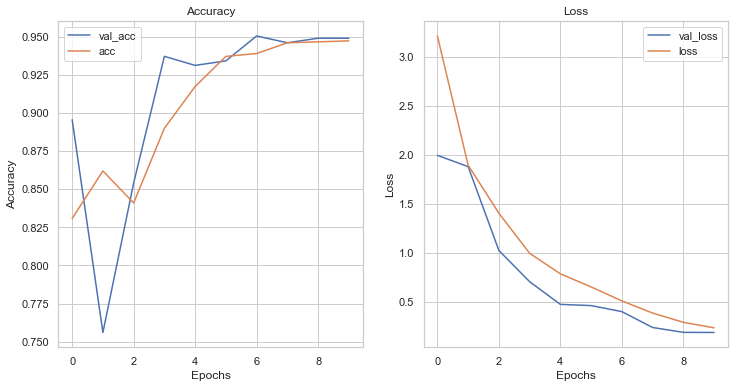

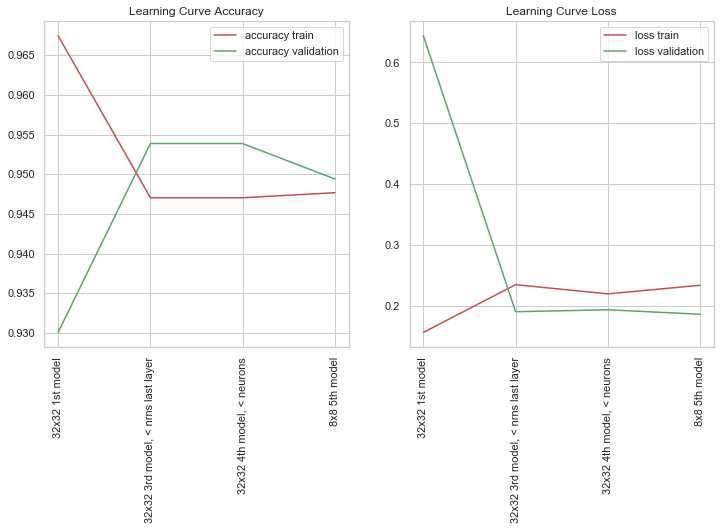

,Name,accuracy train,accuracy validation,loss train,loss validation
0,32x32 1st model,0.96745,0.93006,0.15598,0.64381
0,"32x32 3rd model, < nrns last layer",0.94703,0.95387,0.23444,0.18992
0,"32x32 4th model, < neurons",0.94703,0.95387,0.21926,0.19309
0,8x8 5th model,0.94767,0.94940,0.23345,0.18574


In [125]:
df=model_results(history5, '8x8 5th model', df)
df

The good news is that even if the results change a lot in the first part where I do regualr NN, every time I run the code, they don't change so radically with the CNN.
I will keep track a bit but overall it seems like I can stop worrying about reproducibe results, if I use CNN right away.

In [126]:
model5 = models.Sequential()
model5.add(layers.Conv2D(3, (3, 3), activation='sigmoid',
                        input_shape=(8 ,8,  3)))
model5.add(layers.MaxPooling2D((2, 2)))

model5.add(layers.Flatten())
model5.add(layers.Dense(9, activation='softmax'))

model5.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [127]:
history6= fit_model(model5,train_img8,
                    train_y)

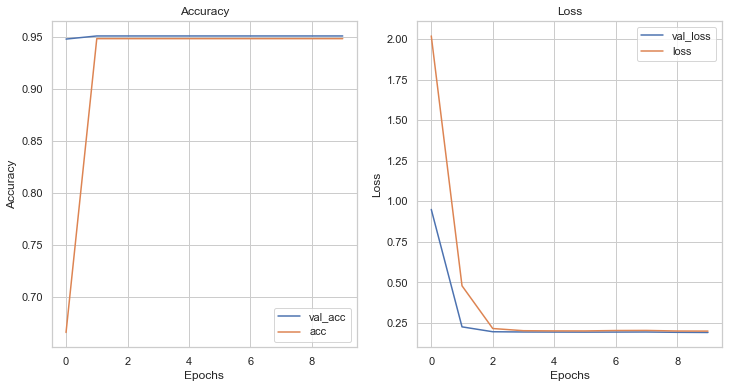

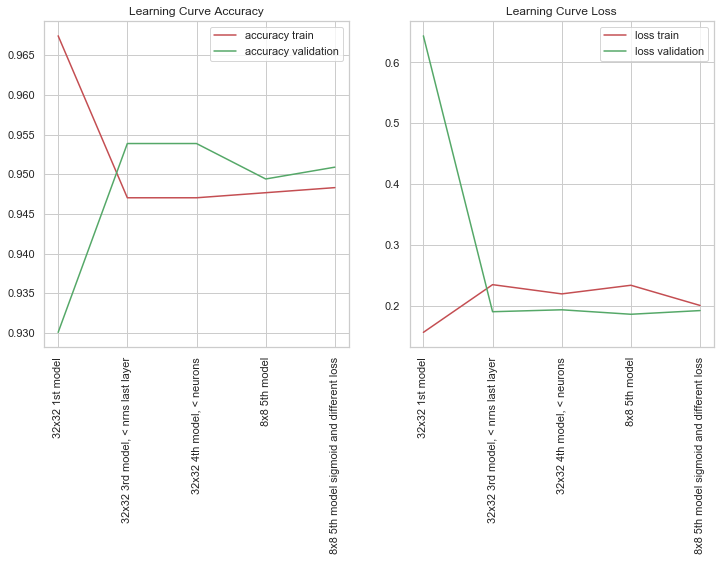

,Name,accuracy train,accuracy validation,loss train,loss validation
0,32x32 1st model,0.96745,0.93006,0.15598,0.64381
0,"32x32 3rd model, < nrns last layer",0.94703,0.95387,0.23444,0.18992
0,"32x32 4th model, < neurons",0.94703,0.95387,0.21926,0.19309
0,8x8 5th model,0.94767,0.94940,0.23345,0.18574
0,8x8 5th model sigmoid and different loss,0.94831,0.95089,0.20021,0.19180


In [128]:
df=model_results(history6, '8x8 5th model sigmoid and different loss', df)
df

## Starting to improve our model:

Taking from the german signs notebook

Nope. It's in AWS Sagemaker. But I can look back at it and use either a simple pipeline for loading and changing the size of the images, or for images augmentation to balance the classes of the different skin anomalies.
<br>A simple pipeline can even be "load, normalize, augment".

#### To improve our model we will take several steps:
   - normalize the data 
   - increase image resolution
   - add more epochs
   - add more layers
   - increase the batch size
   - change activation function and optimization
    
After we have done all this we will select the best performing model and we will also group up into 2 classes, cancerous and benign growth too.
<br>Maybe I should do that now actually.
<br>No I will do it after this first selection so I can say I have a good model to predict which of the 9 classes with this much accuracy.
<br>And then introduce the concept of two classes and decreasing recall.
<br>After that anyhow, do another round of tuning for the model, this time using:
 - drop out layers
 - regularization
 - normalization
 - data augmentation
 - balancing classes with data augmentation
 

### Improving the model with 9 classes:

Restart with an empty dataframe because while before we were looking for the lowest performance model now we are looking to improve it.

In [168]:
df = pd.DataFrame()

Let us start by visualizing again the results from what we picked to be our naive model:

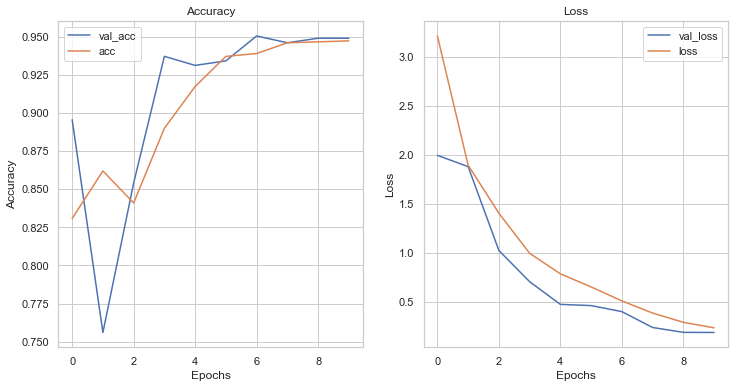

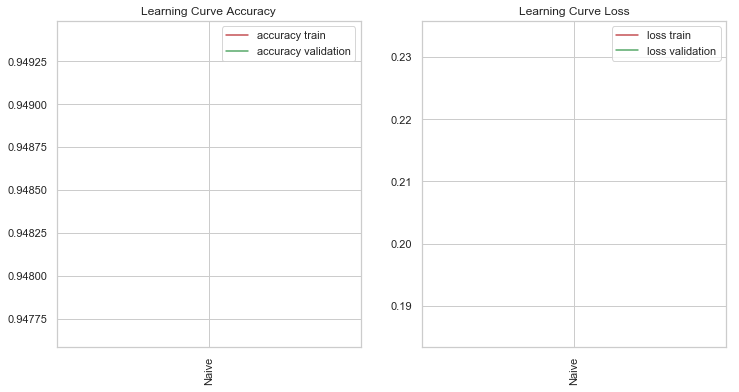

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.94767,0.9494,0.23345,0.18574


In [169]:
df=model_results(history5, 'Naive', df)
df

#### Normalize the data:

In [139]:
train_img8[0][1]

array([[0.85490197, 0.5411765 , 0.69411767],
       [0.8862745 , 0.57254905, 0.6784314 ],
       [0.8784314 , 0.50980395, 0.6431373 ],
       [0.8784314 , 0.4392157 , 0.61960787],
       [0.8980392 , 0.53333336, 0.7058824 ],
       [0.8666667 , 0.50980395, 0.6392157 ],
       [0.8745098 , 0.53333336, 0.69803923],
       [0.89411765, 0.5921569 , 0.73333335]], dtype=float32)

As we can see the RGB values of each pixel are not scaled, we are going to scale their value between 0 and 1 by dividing each pixel value by 225.
To standardize the pixel values:

In [132]:
train_img8 /= 255.

In [140]:
train_img8[0][1]

array([[0.85490197, 0.5411765 , 0.69411767],
       [0.8862745 , 0.57254905, 0.6784314 ],
       [0.8784314 , 0.50980395, 0.6431373 ],
       [0.8784314 , 0.4392157 , 0.61960787],
       [0.8980392 , 0.53333336, 0.7058824 ],
       [0.8666667 , 0.50980395, 0.6392157 ],
       [0.8745098 , 0.53333336, 0.69803923],
       [0.89411765, 0.5921569 , 0.73333335]], dtype=float32)

In [170]:
history52 = fit_model(model5, train_img8,train_y)

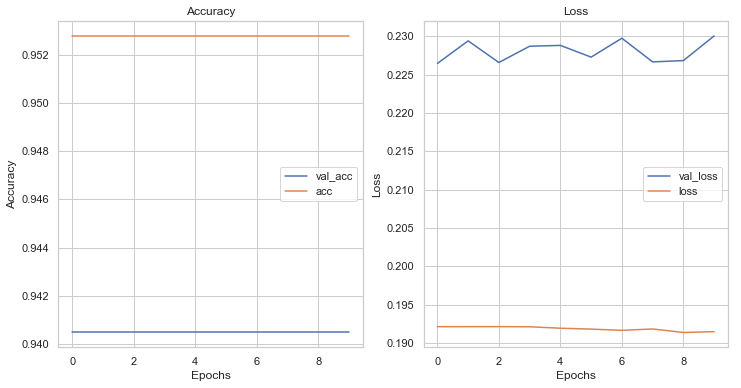

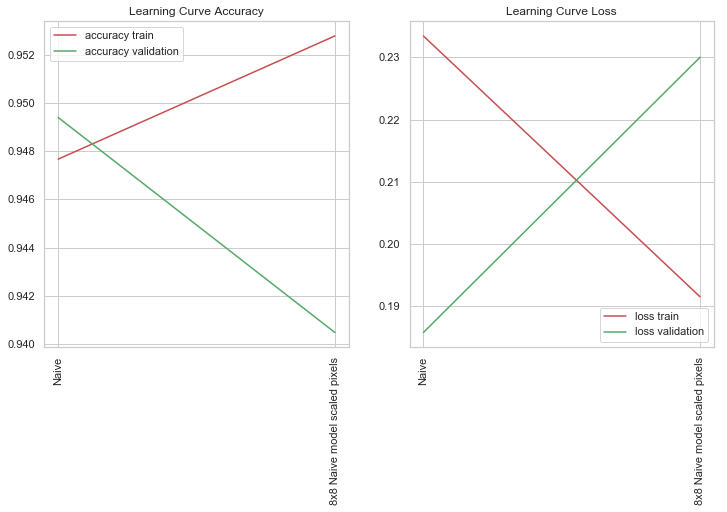

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.94767,0.94940,0.23345,0.18574
0,8x8 Naive model scaled pixels,0.95278,0.94048,0.19148,0.23003


In [171]:
df=model_results(history52, '8x8 Naive model scaled pixels', df)
df

#### Adding more layers:

Let us move on from the basic naive model to a more structured one with more layers.
We will define it with a function that will allow us to also tweak other parameters, which is what we will do to keep tuning our model.
With this function we can set all the parameters that we want, input_shape, activation function, loss, optimizer algorithm, metrics etc.
We will also set most of these parameters as default, except for input shape, to make the execution of the function not too heavy.

In [193]:
def create_model(input_shape=(64, 64, 3), activation='relu', 
                 loss='sparse_categorical_crossentropy', 
                optimizer='rmsprop',metrics=['acc'] , 
                 neur1=5, neur2=5, pool=(2,2)):
 # create model
    model = models.Sequential()
    model.add(layers.Conv2D(neur1, (3, 3), activation=activation,
                        input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool))
    
    model.add(layers.Conv2D(neur1, (4, 4), activation=activation))
    model.add(layers.MaxPooling2D(pool))

    model.add(layers.Conv2D(neur2, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation=activation))
    model.add(layers.Dense(9, activation='softmax'))

# Compile model
    model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)
    return model

In [194]:
model_a=create_model(input_shape=(32,32,3))

In [195]:
history1 = fit_model(model_a, train_img32,train_y)

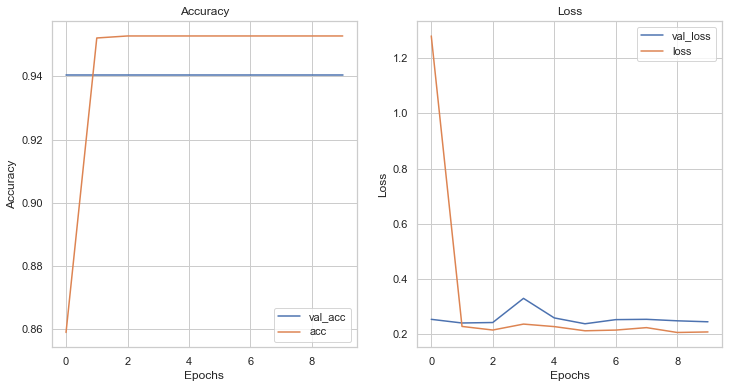

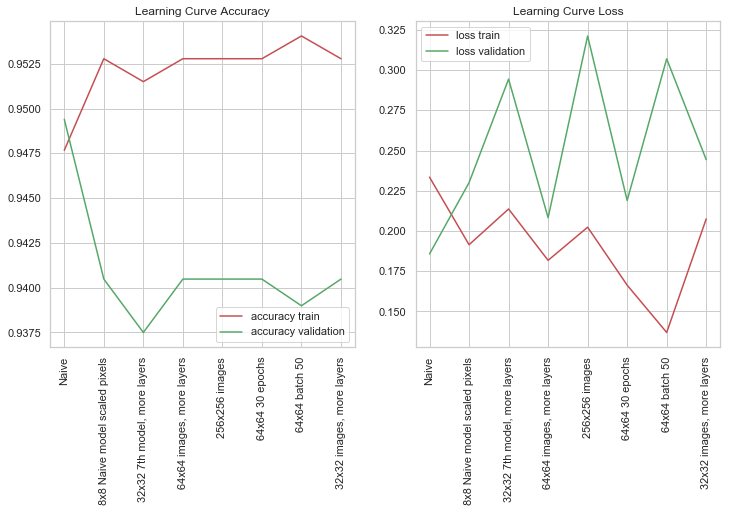

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.94767,0.94940,0.23345,0.18574
0,8x8 Naive model scaled pixels,0.95278,0.94048,0.19148,0.23003
0,"32x32 7th model, more layers",0.95150,0.93750,0.21367,0.29437
0,"64x64 images, more layers",0.95278,0.94048,0.18178,0.20827
0,256x256 images,0.95278,0.94048,0.20236,0.32118
0,64x64 30 epochs,0.95278,0.94048,0.16637,0.21894
0,64x64 batch 50,0.95405,0.93899,0.13696,0.30697
0,"32x32 images, more layers",0.95278,0.94048,0.20753,0.24434


In [196]:
df=model_results(history1, '32x32 images, more layers', df)
df

#### Increasing Image resolution:
Importing images with 64x64 image resolution.

In [158]:
# Directory path
train_data_dir = 'dataskin/Train'
#test_data_dir = 'dataskin/Test'

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(64, 64), batch_size=2239)

# Create the datasets
train_img64, train_lab = next(train_gen)
#test_img64, test_lab = next(test_gen)

#normalizing again
train_img64 /= 255.
#test_img64 /= 255.

Found 2239 images belonging to 9 classes.


In [160]:
train_y = np.reshape(train_lab[:,0], (2239,1))
#test_y = np.reshape(test_lab[:,0], (118,1))

In [200]:
# No need to specify input shape, since the default is 64x64
model_b=create_model()

In [198]:
history2 = fit_model(model_b, train_img64, train_y)

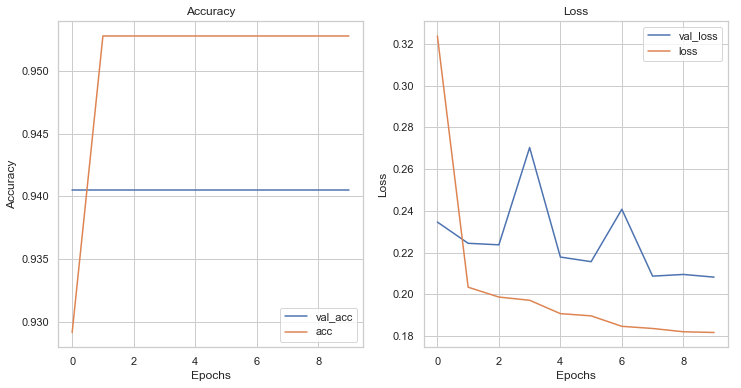

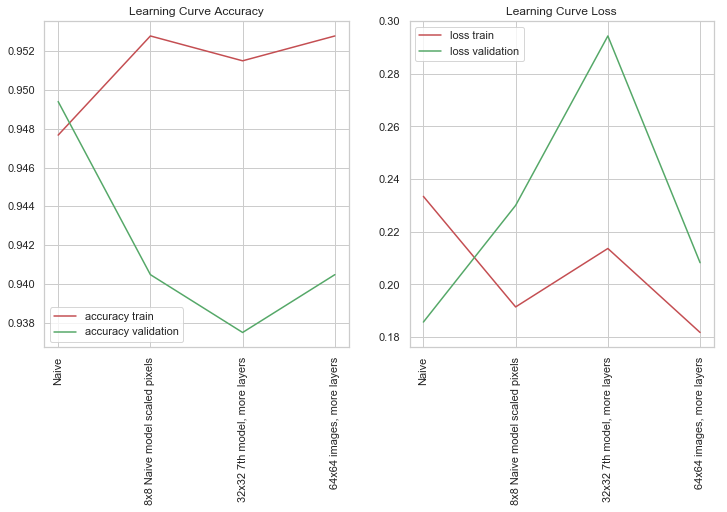

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.94767,0.94940,0.23345,0.18574
0,8x8 Naive model scaled pixels,0.95278,0.94048,0.19148,0.23003
0,"32x32 7th model, more layers",0.95150,0.93750,0.21367,0.29437
0,"64x64 images, more layers",0.95278,0.94048,0.18178,0.20827


In [181]:
df=model_results(history2, '64x64 images, more layers', df)
df

#### Full size of the images

Let us try increasing the size of the images imported further. Let us go all the way to the actually full size which is 256. These are already loaded at the beginning and are sotred in train_images_fs, test_images_fs.

In [182]:
#normalizing again
train_images_fs /= 255.
test_images_fs /= 255.

In [183]:
model_c=create_model(input_shape=(256,256,3))

In [184]:
history3 = fit_model(model_c, train_images_fs,train_y)

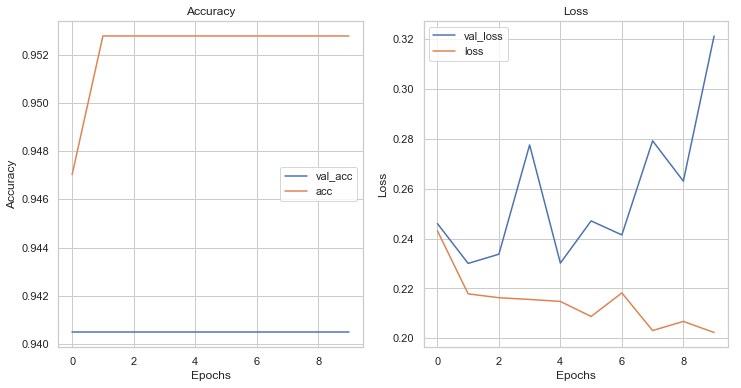

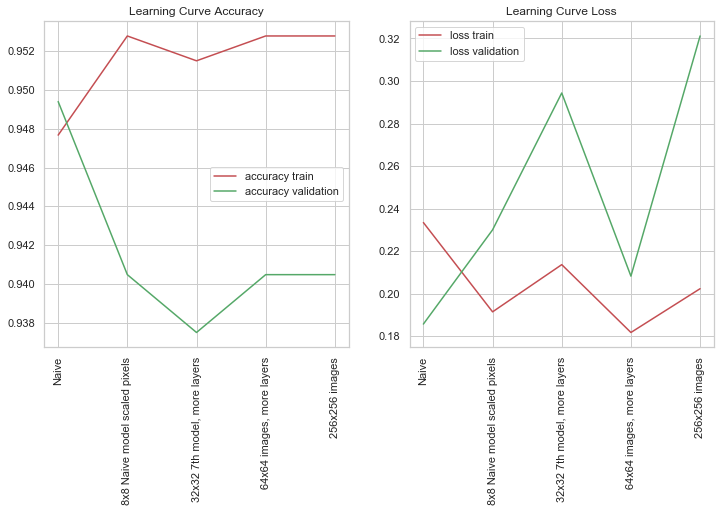

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.94767,0.94940,0.23345,0.18574
0,8x8 Naive model scaled pixels,0.95278,0.94048,0.19148,0.23003
0,"32x32 7th model, more layers",0.95150,0.93750,0.21367,0.29437
0,"64x64 images, more layers",0.95278,0.94048,0.18178,0.20827
0,256x256 images,0.95278,0.94048,0.20236,0.32118


In [185]:
df=model_results(history3, '256x256 images', df)
df

Let us see what happens with the full size.

#### Increasing number of epochs:
Keeping the same model, but we will do it with images sizes 64 to reduce running time.

In [186]:
history4=fit_model(model_b, train_img64, train_y, epo=30)

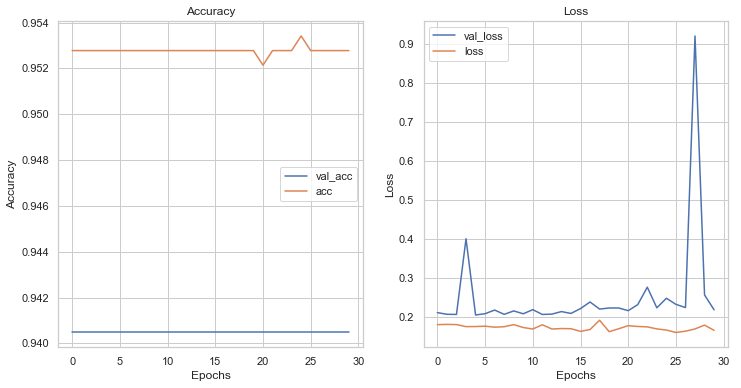

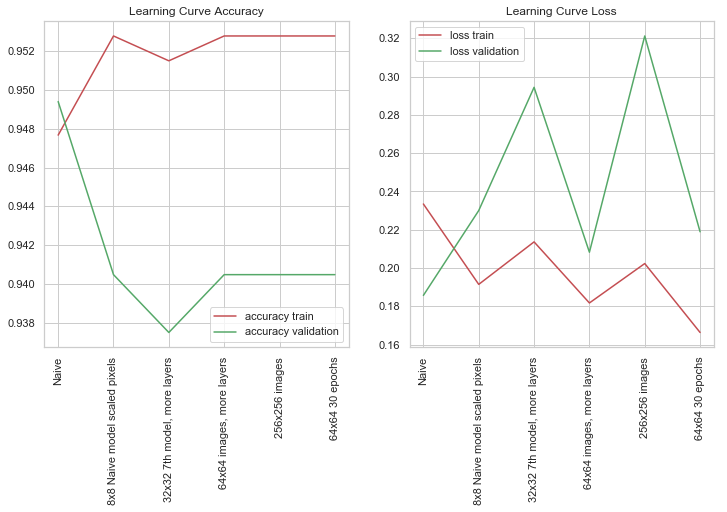

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.94767,0.94940,0.23345,0.18574
0,8x8 Naive model scaled pixels,0.95278,0.94048,0.19148,0.23003
0,"32x32 7th model, more layers",0.95150,0.93750,0.21367,0.29437
0,"64x64 images, more layers",0.95278,0.94048,0.18178,0.20827
0,256x256 images,0.95278,0.94048,0.20236,0.32118
0,64x64 30 epochs,0.95278,0.94048,0.16637,0.21894


In [187]:
df=model_results(history4, '64x64 30 epochs', df)
df

#### Increase the batch size: 50

In [189]:
history5=fit_model(model_b, train_img64, train_y, epo=30, batch=50)

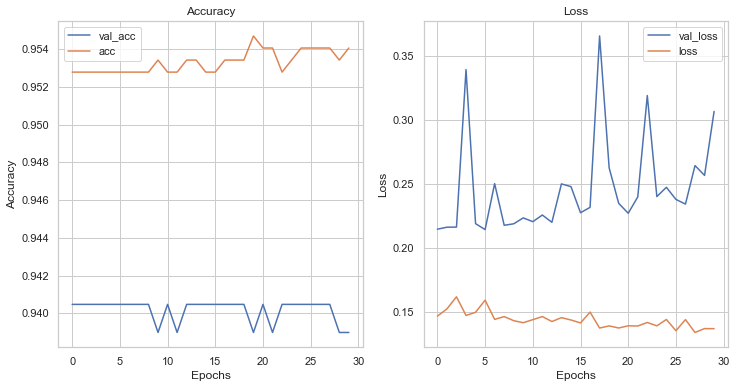

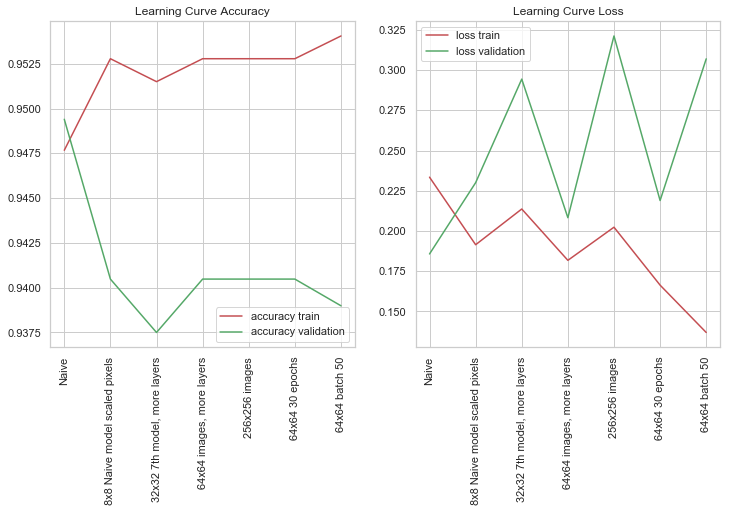

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.94767,0.94940,0.23345,0.18574
0,8x8 Naive model scaled pixels,0.95278,0.94048,0.19148,0.23003
0,"32x32 7th model, more layers",0.95150,0.93750,0.21367,0.29437
0,"64x64 images, more layers",0.95278,0.94048,0.18178,0.20827
0,256x256 images,0.95278,0.94048,0.20236,0.32118
0,64x64 30 epochs,0.95278,0.94048,0.16637,0.21894
0,64x64 batch 50,0.95405,0.93899,0.13696,0.30697


In [190]:
df=model_results(history5, '64x64 batch 50', df)
df

The truth is that just getting one result for each of these attempts doesn't really tell us too much about the improvement or not of our model, because of the randomness of the results.
What would be more appropriate is for each change we do (in the size of the images, the number of epochs, the batch size) to try a few different values to be able to really get a sense of in which direction our model is moving with that change.
This would be very time consuming to do by hand, so the next step we are goign to take is building a grid search for these parameteres to get a better answer in terms of which ones are the optimal charateristic of our model, which gives us the best accuracy in determining the classification of the skin anomaly.

### Grid Search batch size and epochs:

Grid search is a model hyperparameter optimization technique.
In scikit learn this is a class, and when running a search with this class, we must input a dictionary of hyperparameters to evaluate in the param_grid argument. 
This dictionary contains the model parameter name and an array of values to try.

The GridSearchCV essentially builds and then evaluates one model for each combination of parameters. 
To evaluate each individual model, a 3-fold cross validation is used.

Even if we might have seen a better result with higher resolution images, we will keep the 64x64 ones for the grid search to limit the running time of our code.
Once we  find out from the GridSearch what are the best parameteres we can use those (running just one single model) with higher resolution images.

In [191]:
# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

#set X and Y
X=train_img64
Y=train_y

In [214]:
"""# Use scikit-learn to grid search the batch size and epochs
# create model
model = KerasClassifier(model=create_model())
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)

#code from Jason Brownlee on https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
"""

'# Use scikit-learn to grid search the batch size and epochs\n# create model\nmodel = KerasClassifier(model=create_model())\n# define the grid search parameters\nbatch_size = [10, 20, 40, 60, 80, 100]\nepochs = [10, 50, 100]\nparam_grid = dict(batch_size=batch_size, epochs=epochs)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X, Y)\n\n#code from Jason Brownlee on https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/\n'

In [215]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

'\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))\n    '

In [203]:
#best_params=grid_result.best_params_
#best_params

{'batch_size': 10, 'epochs': 10}

In [204]:
#best_batch=grid_result.best_params_['batch_size']

In [216]:
best_batch=10

In [217]:
#best_epochs=grid_result.best_params_['epochs']

In [218]:
best_epochs=10

Now we can run again a model with the higher resolution images, using the best parameters we obtained from the grid search.

In [219]:
history6 = fit_model(model_b, train_img64, train_y,
                    epo=best_epochs,
                    batch=best_batch)

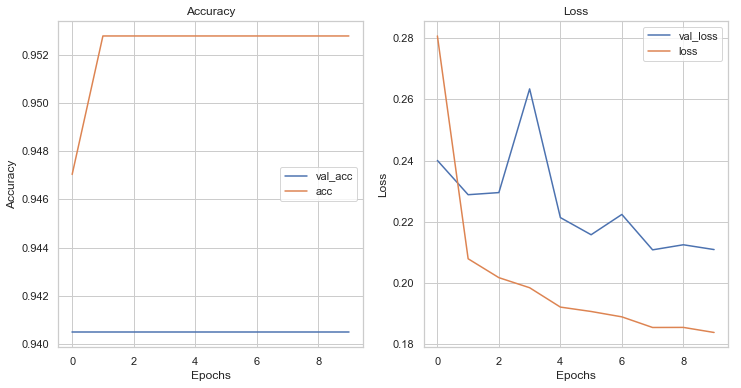

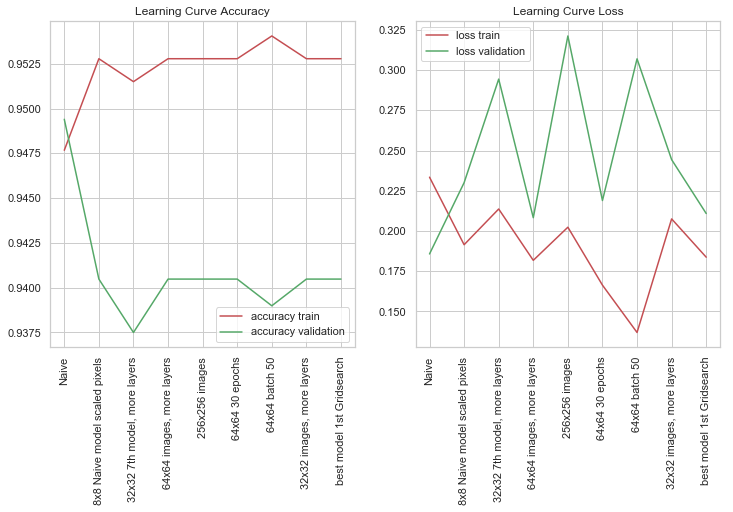

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.94767,0.94940,0.23345,0.18574
0,8x8 Naive model scaled pixels,0.95278,0.94048,0.19148,0.23003
0,"32x32 7th model, more layers",0.95150,0.93750,0.21367,0.29437
0,"64x64 images, more layers",0.95278,0.94048,0.18178,0.20827
0,256x256 images,0.95278,0.94048,0.20236,0.32118
0,64x64 30 epochs,0.95278,0.94048,0.16637,0.21894
0,64x64 batch 50,0.95405,0.93899,0.13696,0.30697
0,"32x32 images, more layers",0.95278,0.94048,0.20753,0.24434
0,best model 1st Gridsearch,0.95278,0.94048,0.18373,0.21086


In [210]:
df=model_results(history6, 'best model 1st Gridsearch', df)
df

### Grid Search Optimization Algorithm:

We can run again a GridSearch, but this time instead of trying different numbers of epochs and batch sizes, we will try different optimization algorithms. Here is a lists of them, and as we can see from the number of options, GridSearch is a good idea to shorten the time in trying all the different possible combinations.

#### Changing activation functions and optimizations:
Some of the options for activation functions are:
<br>relu
<br>swish
<br>softmax
<br>leaky relu
<br>sigmoid

<br>for optimizers:
<br>adam, sgd, 
<br>with optimizer I can also tweak the learning rate

<br>for loss functions:
categorical_crossentropy, 


We already have the function to create the model, and the X and Y we set before are teh same. We just need to change the grid for the search of the parameters.

In [220]:
"""# create model
model = KerasClassifier(model=create_model(), 
                        loss="sparse_categorical_crossentropy", 
                        epochs=best_epochs, batch_size=best_batch)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
#code from Jason Brownlee on https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
"""

'# create model\nmodel = KerasClassifier(model=create_model(), \n                        loss="sparse_categorical_crossentropy", \n                        epochs=best_epochs, batch_size=best_batch)\n# define the grid search parameters\noptimizer = [\'SGD\', \'RMSprop\', \'Adagrad\', \'Adadelta\', \'Adam\', \'Adamax\', \'Nadam\']\nparam_grid = dict(optimizer=optimizer)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X, Y)\n#code from Jason Brownlee on https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/\n'

In [221]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

'\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))\n    '

In [222]:
#best_params=grid_result.best_params_
#best_params

In [223]:
#best_opti=grid_result.best_params_['optimizer']

In [224]:
### Just for now let me add this so we don't have to redo the search
best_opti='sgd'

Creating a new model with the selected optimizer algorithm:

In [225]:
model_d=create_model(optimizer=best_opti)

In [227]:
history7 = fit_model(model_d, train_img64, train_y,
                    epo=best_epochs,
                    batch=best_batch)

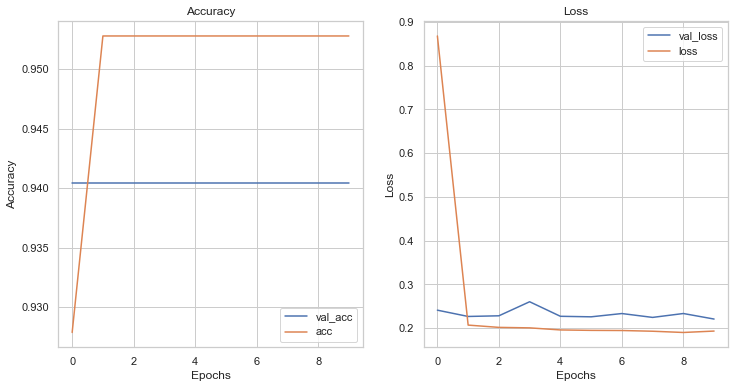

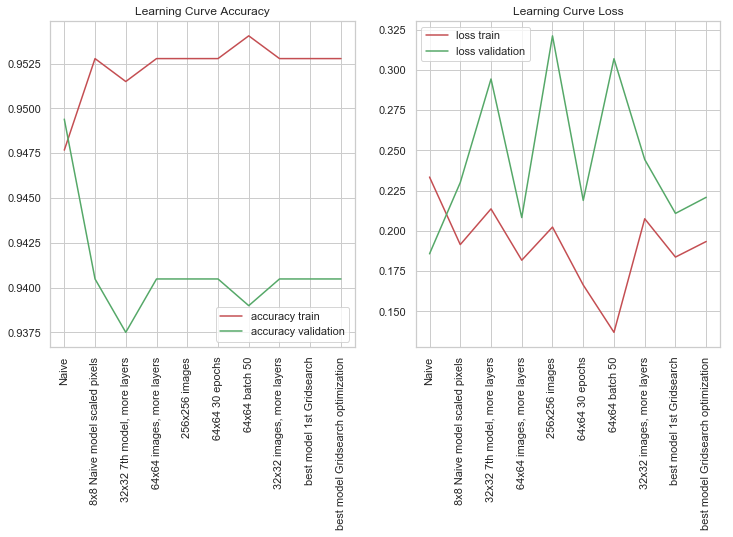

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.94767,0.94940,0.23345,0.18574
0,8x8 Naive model scaled pixels,0.95278,0.94048,0.19148,0.23003
0,"32x32 7th model, more layers",0.95150,0.93750,0.21367,0.29437
0,"64x64 images, more layers",0.95278,0.94048,0.18178,0.20827
0,256x256 images,0.95278,0.94048,0.20236,0.32118
0,64x64 30 epochs,0.95278,0.94048,0.16637,0.21894
0,64x64 batch 50,0.95405,0.93899,0.13696,0.30697
0,"32x32 images, more layers",0.95278,0.94048,0.20753,0.24434
0,best model 1st Gridsearch,0.95278,0.94048,0.18373,0.21086
0,best model Gridsearch optimization,0.95278,0.94048,0.19341,0.22087


In [228]:
df=model_results(history7, 'best model Gridsearch optimization', df)
df

### Grid Search Learning Rate and Momentum

In [230]:
"""# create model
model = KerasClassifier(model=create_model, loss="sparse_categorical_crossentropy", 
                        optimizer="SGD", epochs=10, batch_size=10, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)"""

In [232]:
"""# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))"""

Best: 0.949084 using {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.0}
0.949084 (0.000032) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.0}
0.949084 (0.000032) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.2}
0.949084 (0.000032) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.4}
0.949084 (0.000032) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.6}
0.949084 (0.000032) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.8}
0.949084 (0.000032) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.9}
0.949084 (0.000032) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.0}
0.949084 (0.000032) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.2}
0.949084 (0.000032) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.4}
0.949084 (0.000032) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.6}
0.949084 (0.000032)

Let us print out just the best lesarning rate and momentum:

In [233]:
#best_params=grid_result.best_params_
#best_params

{'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.0}

In [234]:
best_rate=best_params['optimizer__learning_rate']
best_rate

0.001

In [236]:
best_rate=0.001

In [235]:
best_momentum=best_params['optimizer__momentum']
               

0.0

In [237]:
best_momentum=0.0

In [239]:
optimizer = tf.keras.optimizers.SGD(learning_rate=best_rate, 
                                    momentum=best_momentum)

In [240]:
model_e=create_model(optimizer=optimizer)

In [241]:
history8= fit_model(model_e, train_img64, train_y,
                     epo=best_epochs,batch=best_batch)

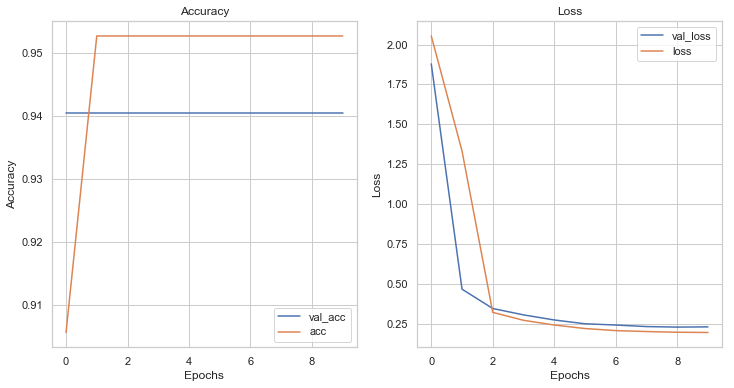

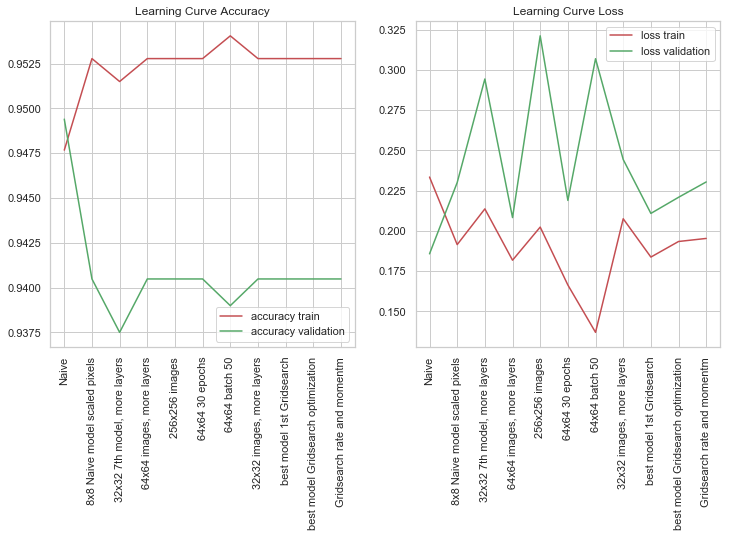

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.94767,0.94940,0.23345,0.18574
0,8x8 Naive model scaled pixels,0.95278,0.94048,0.19148,0.23003
0,"32x32 7th model, more layers",0.95150,0.93750,0.21367,0.29437
0,"64x64 images, more layers",0.95278,0.94048,0.18178,0.20827
0,256x256 images,0.95278,0.94048,0.20236,0.32118
0,64x64 30 epochs,0.95278,0.94048,0.16637,0.21894
0,64x64 batch 50,0.95405,0.93899,0.13696,0.30697
0,"32x32 images, more layers",0.95278,0.94048,0.20753,0.24434
0,best model 1st Gridsearch,0.95278,0.94048,0.18373,0.21086
0,best model Gridsearch optimization,0.95278,0.94048,0.19341,0.22087


In [242]:
df=model_results(history8, 'Gridsearch rate and momentm', df)
df

We could also do a grid search to choose the best activation function, but it doesn't make much sense in our multiclass case because the most popular one is softmax for this case, there aren't really that many options. But we will do this type of grid search later when we will reduce our problem to a binary classification problem, and there will be more options of activation fucntions to use at that point.

What we can still tune though is the number of neurons in the hidden layers.
We will do this with another grid search.

### How to Tune the Neuron Activation Function

In [243]:
"""
# create model
model = KerasClassifier(model=create_model, epochs=10, batch_size=10)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 
              'hard_sigmoid', 'linear']
param_grid = dict(model__activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""

Epoch 1/10
224/224 [==============================] - 8s 27ms/step - loss: 1.5838 - acc: 0.9402
Epoch 2/10
224/224 [==============================] - 6s 26ms/step - loss: 0.9878 - acc: 0.9491
Epoch 3/10
224/224 [==============================] - 6s 27ms/step - loss: 0.6113 - acc: 0.9491
Epoch 4/10
224/224 [==============================] - 8s 34ms/step - loss: 0.3973 - acc: 0.9491
Epoch 5/10
224/224 [==============================] - 7s 30ms/step - loss: 0.2934 - acc: 0.9491
Epoch 6/10
224/224 [==============================] - 6s 26ms/step - loss: 0.2484 - acc: 0.9491
Epoch 7/10
224/224 [==============================] - 6s 27ms/step - loss: 0.2271 - acc: 0.9491
Epoch 8/10
224/224 [==============================] - 6s 26ms/step - loss: 0.2149 - acc: 0.9491
Epoch 9/10
224/224 [==============================] - 8s 35ms/step - loss: 0.2067 - acc: 0.9491
Epoch 10/10
224/224 [==============================] - 6s 28ms/step - loss: 0.2014 - acc: 0.9491


In [244]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))"""

Best: 0.949084 using {'model__activation': 'softmax'}
0.949084 (0.000032) with: {'model__activation': 'softmax'}
0.949084 (0.000032) with: {'model__activation': 'softplus'}
0.949084 (0.000032) with: {'model__activation': 'softsign'}
0.949084 (0.000032) with: {'model__activation': 'relu'}
0.949084 (0.000032) with: {'model__activation': 'tanh'}
0.949084 (0.000032) with: {'model__activation': 'sigmoid'}
0.949084 (0.000032) with: {'model__activation': 'hard_sigmoid'}
0.944169 (0.006967) with: {'model__activation': 'linear'}


Best activation function is:

In [245]:
#best_params=grid_result.best_params_
#best_params

{'model__activation': 'softmax'}

In [246]:
#best_function=best_params['model__activation']

'softmax'

In [247]:
best_function='softmax'

In [248]:
model_f=create_model(activation=best_function, optimizer=optimizer)

In [249]:
history9= fit_model(model_f, train_img64, train_y,
                     epo=best_epochs, batch=best_batch)

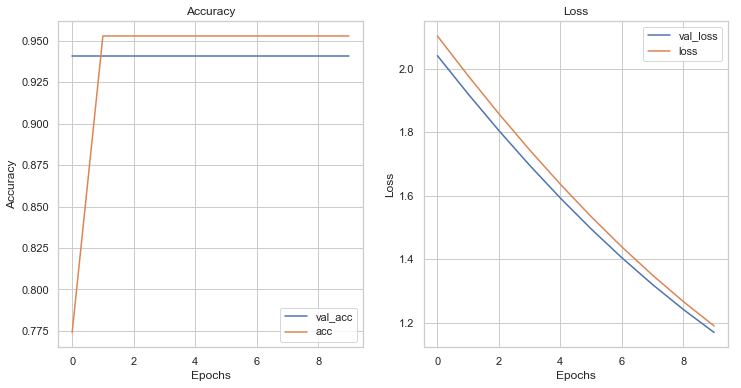

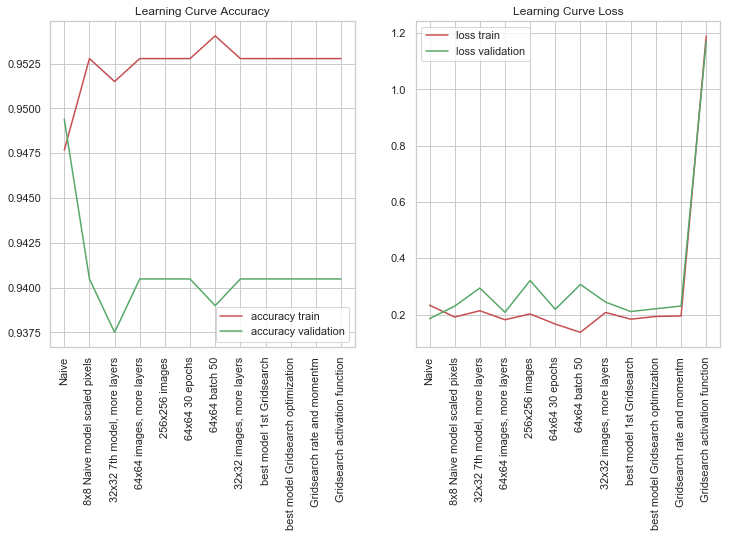

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.94767,0.94940,0.23345,0.18574
0,8x8 Naive model scaled pixels,0.95278,0.94048,0.19148,0.23003
0,"32x32 7th model, more layers",0.95150,0.93750,0.21367,0.29437
0,"64x64 images, more layers",0.95278,0.94048,0.18178,0.20827
0,256x256 images,0.95278,0.94048,0.20236,0.32118
0,64x64 30 epochs,0.95278,0.94048,0.16637,0.21894
0,64x64 batch 50,0.95405,0.93899,0.13696,0.30697
0,"32x32 images, more layers",0.95278,0.94048,0.20753,0.24434
0,best model 1st Gridsearch,0.95278,0.94048,0.18373,0.21086
0,best model Gridsearch optimization,0.95278,0.94048,0.19341,0.22087


In [250]:
df=model_results(history9, 'Gridsearch activation function', df)
df

### Grid Search number of neurons:

For this grid search we have to slightly modify our `create_model` function, since we are going to search 4 different numbers of neurons for each layer, there's no need to separate between the first 3 layers and the last one.

In [272]:
# Function to create model, required for KerasClassifier
def create_model(neurons):
 # create model
    model = models.Sequential()
    model.add(layers.Conv2D(neurons, (3, 3), activation='softmax',
                        input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(neurons, (4, 4), activation='softmax'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(neurons, (3, 3), activation='softmax'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='softmax'))
    model.add(layers.Dense(9, activation='softmax'))

# Compile model
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer=best_opti,
              metrics=['acc'])
    return model

In [261]:
# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)
#set X and Y
X=train_img64
Y=train_y

In [263]:
"""# create model
model = KerasClassifier(model=create_model, epochs=10, batch_size=10, verbose=0)
# define the grid search parameters
neurons = [1, 5, 10, 15, 20, 25, 30]
param_grid = dict(model__neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""
#code from Jason Brownlee on https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [264]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

Best: 0.949084 using {'model__neurons': 1}
0.949084 (0.000032) with: {'model__neurons': 1}
0.949084 (0.000032) with: {'model__neurons': 5}
0.949084 (0.000032) with: {'model__neurons': 10}
0.949084 (0.000032) with: {'model__neurons': 15}
0.949084 (0.000032) with: {'model__neurons': 20}
0.949084 (0.000032) with: {'model__neurons': 25}
0.949084 (0.000032) with: {'model__neurons': 30}


In [265]:
#grid_result.best_params_

{'model__neurons': 1}

In [300]:
#neurons=grid_result.best_params_
#neurons

{'model__neurons': 1}

model_neurons 1. Doesn't make sense. But it's also because all the results are the same. We will choose a standard value and pick 10.

In [268]:
best_neurons=10

In [ ]:
model_g=create_model(activation=best_function, optimizer=optimizer,
                     neur1=best_neurons)

In [ ]:
history10 = fit_model(model_g, train_img64,train_y,
                     epo=best_epochs,batch=best_batch)

In [ ]:
df=model_results(history10, 'Gridsearch neurons', df)
df

## Tuning

Now that we selected all the best parameters for our model, there is some more tuning that we can do in particular to make sure that our model will not overfit the data.
This is achieved with regularization, dropout layers and early stopping.

### Regularization

Regularization is commonly used when the model is overfitting the data.
The main idea of regularization therefore is to penalize in some way a model that is too complex, that will tend to overfit the data.
L1 regularization just adds one parameter, is not commonly used in Neural Networks.
L2 on the other hand, also called "weigth decay", makes the weights smaller, penalizing especially the largest weights, in a way forcing the model to be simplified.

In [296]:
from tensorflow.keras import regularizers

model_h = models.Sequential()
model_h.add(layers.Conv2D((best_neurons, (3, 3)), activation='softmax'))
model_h.add(layers.MaxPooling2D((2, 2)))
    
model_h.add(layers.Conv2D((best_neurons, (4, 4)), activation='softmax'))
#                         ,kernel_regularizer=regularizers.L2(l2=0.05)))
model_h.add(layers.MaxPooling2D((2, 2)))
model_h.add(layers.Conv2D((best_neurons, (3, 3)), activation='softmax')) 
#                        ,kernel_regularizer=regularizers.L2(l2=0.05)))
model_h.add(layers.MaxPooling2D((2, 2)))

model_h.add(layers.Flatten())
model_h.add(layers.Dense(32, activation='relu')) 
#                       ,kernel_regularizer=regularizers.L2(l2=0.05)))
model_h.add(layers.Dense(9, activation='softmax'))

# Compile model
model_h.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])


TypeError: '<' not supported between instances of 'tuple' and 'int'

In [299]:
# create model
model = models.Sequential()
model.add(layers.Conv2D((10, (3, 3))))
model.add(layers.MaxPooling2D(2,2))
    
model.add(layers.Conv2D(10, (4, 4),
                        kernel_regularizer=regularizers.L2(l2=0.05)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32, (3, 3), activation='softmax',
                        kernel_regularizer=regularizers.L2(l2=0.05)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

TypeError: __init__() missing 1 required positional argument: 'kernel_size'

In [ ]:
history11 = fit_model(model_h, train_img64, train_y,
                    epochs=best_epochs,
                    batch_size=best_batch)

In [ ]:
df=model_results(history11, 'after regularization', df)
df

>Play around a bit and find the best parameters for L2.

### Dropout Regularization

Dropout layers, forces the model to block out some nodes, for the model to not rely heavily on certain paths.

In [ ]:
# Function to create model, required for KerasClassifier
def create_model_drop(dropout_rate, weight_constraint):

model = models.Sequential()
model.add(layers.Conv2D(neurons=(best_neurons, (3, 3), activation='relu',
                        input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
    
model.add(layers.Conv2D(neurons=(best_neurons, (4, 4), activation='relu',
                         kernel_regularizer=regularizers.L2(l2=0.05)), 
                          kernel_constraint=MaxNorm(weight_constraint))
model.add(layers.MaxPooling2D((2, 2)))
# Implement dropout to the first hidden layer 
model.add(layers.Dropout(dropout_rate))
            

model.add(layers.Conv2D(neurons=(best_neurons, (3, 3), activation='relu', 
                        kernel_regularizer=regularizers.L2(l2=0.05)), 
                          kernel_constraint=MaxNorm(weight_constraint))
model.add(layers.MaxPooling2D((2, 2)))
            
# Implement dropout to the second hidden layer 
model.add(layers.Dropout(dropout_rate))            

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu', 
                       kernel_regularizer=regularizers.L2(l2=0.05)))
model.add(layers.Dense(9, activation='softmax'))

# Compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [ ]:
# create model
model = KerasClassifier(model=create_model_drop, epochs=10, batch_size=10)
# define the grid search parameters
weight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(model__dropout_rate=dropout_rate, model__weight_constraint=weight_constraint)
#param_grid = dict(model__dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
grid_result.best_params_

In [ ]:
best_drop=

Now that it is clear from the grid search what is the best drop out rate let us create our model with it and see the results in comparison to the other models.

In [ ]:
model_i = models.Sequential()
model_i.add(layers.Conv2D(neurons=(best_neurons, (3, 3), activation='relu',
                        input_shape=(64, 64, 3)))
model_i.add(layers.MaxPooling2D((2, 2)))
    
model_i.add(layers.Conv2D(neurons=(best_neurons, (4, 4), activation='relu',
                         kernel_regularizer=regularizers.L2(l2=0.05)), 
                          kernel_constraint=MaxNorm(weight_constraint))
model_i.add(layers.MaxPooling2D((2, 2)))
# Implement dropout to the first hidden layer 
model_i.add(layers.Dropout(best_drop))
            

model_i.add(layers.Conv2D(neurons=(best_neurons, (3, 3), activation='relu', 
                        kernel_regularizer=regularizers.L2(l2=0.05)), 
                          kernel_constraint=MaxNorm(weight_constraint))
model_i.add(layers.MaxPooling2D((2, 2)))
            
# Implement dropout to the second hidden layer 
model_i.add(layers.Dropout(best_drop))            

model_i.add(layers.Flatten())
model_i.add(layers.Dense(32, activation='relu', 
                       kernel_regularizer=regularizers.L2(l2=0.05)))
model_i.add(layers.Dense(9, activation='softmax'))

# Compile model
model_i.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [ ]:
history12 = fit_model(model_i, train_img64, train_y,
                    epochs=best_epochs,
                    batch_size=best_batch)

In [ ]:
df=model_results(history12, 'after dropout', df)
df

### Early Stopping

Early stopping: stopping the model from training for the all epochs specified, the model will train for less epochs.
Overfitting neural networks is something you ***want*** to avoid at all costs. However, it's not possible to know in advance how many *epochs* you need to train your model on, and running the model multiple times with varying number of *epochs* maybe helpful, but is a time-consuming process.

We've defined a model with the same architecture as above. This time specify an early stopping point when training the model.

In [ ]:
# Import EarlyStopping and ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping =  [EarlyStopping(monitor='val_loss', patience=10), 
                   ModelCheckpoint(filepath='best_model.h5', monitor= "val_loss",
    save_best_only=True)]

In [ ]:
history13 = fit_model(model_i, train_img64, train_y,
                epochs=best_epochs,
                batch_size=best_batch,
                callbacks=early_stopping)

In [ ]:
df=model_results(history11, 'after early_stopping', df)
df

#### Best model

#### Testing on the test

## Changing to two classes cancerous and bening

In [ ]:
# Work on the data

In [ ]:
# If there is an imbalance re balance the classes with augmentation

In [ ]:
# Create function to extract recall

In [ ]:
y_hat_train=model.predict(train_img)
y_hat_test=model.predict(test_img)

Clearly here I have to round to get the actual prediction for the class.

In [ ]:
pr_train=precision_score(train_labels, train_labels, average=None)
#rec_train=recall_score(train_labels, y_hat_train)
#acc_train=accuracy_score(train_labels, y_hat_train)
#f1_train=f1_score(train_labels, y_hat_train)

#pr_test=precision_score(test_labels, y_hat_test)
#rec_test=recall_score(test_labels, y_hat_test)
#acc_test=accuracy_score(test_labels, y_hat_test)
#f1_test=f1_score(test_labels, y_hat_test)
pr_train
#print("Train: \nprecision", pr_train,"\nrecall:", rec_train, '\naccuracy:', acc_train, '\nf1 score:', f1_train,'\n')
#print("Test: \nprecision", pr_test,"\nrecall:", rec_test, '\naccuracy:', acc_test, '\nf1 score:', f1_test)

In [ ]:
# Create function to compare the models (similar to previous one but comparing recall)

### Re tuning of the parameters
With this time binary classification problem

In [ ]:
# Grid Searches

In [ ]:
# Tuning with normalization and regularization

In [ ]:
# Best model

In [ ]:
# Testing on the test set

## LIME